# 数据清洗

导入相关包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

导入数据文件ab_data.csv，存储在page_df中，并查看前几行：

In [2]:
page_df=pd.read_csv('ab_data.csv')
page_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


查看 数据集行数 和 独立用户数

In [3]:
print('数据行数：', page_df.shape[0])
print('独立用户数：', page_df.user_id.nunique())

数据行数： 294478
独立用户数： 290584


In [4]:
page_df[page_df.user_id.duplicated(keep=False)].sort_values(by = 'user_id').head(10)

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0
207211,630320,2017-01-07 18:02:43.626318,control,old_page,0
255753,630320,2017-01-12 05:27:37.181803,treatment,old_page,0
96929,630471,2017-01-07 02:14:17.405726,control,new_page,0
110634,630471,2017-01-23 01:42:51.501851,control,old_page,0


查看group和landing_page不匹配的数量

In [5]:
mismatch = ((page_df['group'] == 'treatment') != (page_df['landing_page'] == 'new_page'))
print('不匹配数：', mismatch.sum())

不匹配数： 3893


In [6]:
match_df = page_df[~mismatch].copy()  # ~表示按位取反

再次查看行数与独立用户数

In [7]:
print('数据行数：', match_df.shape[0])
print('独立用户数：', match_df.user_id.nunique())

数据行数： 290585
独立用户数： 290584


查看重复值

In [8]:
match_df[match_df.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


删去重复值

In [9]:
match_df = match_df.drop_duplicates(subset=['user_id'], keep='last')

检查缺失值

In [10]:
match_df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

收到新页面的用户占比多少？

In [11]:
match_df[match_df.landing_page=="new_page"].shape[0]/match_df.shape[0]

0.5000619442226688

# A/B 测试

零假设：**$p_{old}$-$p_{new}$>=0**

备择假设：**$p_{old}$-$p_{new}$<0**

n>30的样本去估计总体的未知均值和未知方差，不要求总体分布是否是似正态分布，因为中心极限定理，样本均值服从正态分布，总体方差可以用样本方差来估计，用Z检验。

alpha取0.05

## 直接计算

In [12]:
n_old = match_df[match_df.landing_page=="old_page"].shape[0]
n_new = match_df[match_df.landing_page=="new_page"].shape[0]
n_old, n_new

(145274, 145310)

In [13]:
convert_old = match_df.query('group=="control" & converted==1').shape[0]
convert_new = match_df.query('group=="treatment" & converted==1').shape[0]
convert_old, convert_new

(17489, 17872)

In [14]:
p_old = convert_old / n_old
p_new = convert_new / n_new
p_old, p_new

(0.1203863045004612, 0.12299222352212512)

In [15]:
print('旧版总受试用户数:', n_old, '旧版转化用户数:', convert_old, '旧版转化率:', p_old)
print('新版总受试用户数:', n_new, '新版转化用户数:', convert_new, '新版转化率:', p_new)

旧版总受试用户数: 145274 旧版转化用户数: 17489 旧版转化率: 0.1203863045004612
新版总受试用户数: 145310 新版转化用户数: 17872 新版转化率: 0.12299222352212512


In [16]:
p_c = (convert_old + convert_new)/(n_old + n_new)
print('转化率的联合估计:', p_c)

转化率的联合估计: 0.12168942543292129


In [17]:
z = (p_old - p_new)/ np.sqrt(p_c*(1 - p_c)*( 1/n_old + 1/n_new))
print('检验统计量z:', z)

检验统计量z: -2.1484056695589


In [18]:
from scipy.stats import norm
z_alpha = norm.ppf(0.05)
# 查表-单侧
# 双侧的0.05其实是单侧的0.025，即1.96 
z_alpha

-1.6448536269514729

差异度量 Cohen’s d

In [19]:
n_old, n_new

(145274, 145310)

In [20]:
p_old, p_new

(0.1203863045004612, 0.12299222352212512)

In [21]:
# 合并标准差
std_old = match_df[match_df.landing_page=="old_page"].converted.std()
std_new = match_df[match_df.landing_page=="new_page"].converted.std()
s = np.sqrt(((n_old - 1)* std_old**2 + (n_new - 1)* std_new**2 ) / (n_old + n_new - 2))
# 效应量Cohen's d
d = (p_old - p_new) / s
print('Cohen\'s d为：', d)

Cohen's d为： -0.007970992391336005


## 函数计算

使用 `stats.proportions_ztest` 来计算检验统计量z与p值。[官方文档](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html#statsmodels.stats.proportion.proportions_ztest)

In [22]:
import statsmodels.stats.proportion as sp
z_score, p_value = sp.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('检验统计量z:', z_score, '，p值:', p_value)

检验统计量z: -2.1484056695589 ，p值: 0.015840771394875417


使用 `stats.weightstats.ztest` 来计算检验统计量z与p值。
[官方文档](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html)

In [23]:
import statsmodels.stats.weightstats as sw
z_score1, p_value1 = sw.ztest(match_df.query('landing_page=="old_page"')['converted'], match_df.query('landing_page=="new_page"')['converted'],
                        alternative='smaller')
print('检验统计量z:', z_score1, '，p值:', p_value1)

检验统计量z: -2.148415338961362 ，p值: 0.01584038766094882


## 蒙特卡洛法

在零假设的前提下，p_old和p_new相等时为临界情况（即零假设前提下最接近备择假设的情况）。
如果连相等的情况都能拒绝，那么零假设的剩下部分就更能够拒绝了。
取p_old = p_new = p_all

进行一次模拟：
以总体的p_all为新旧版共同的转化率均值，分别进行n_old和n_new次0-1抽样，使模拟的样本大小同ab_data.csv中的样本大小相同。

In [25]:
p_all = match_df.converted.mean()
print('p_all:', p_all)

p_all: 0.12168942543292129


In [26]:
old_page = np.random.choice(2, size=n_old, p=[1-p_all, p_all])
new_page = np.random.choice(2, size=n_new, p=[1-p_all, p_all])
diff = old_page.mean() - new_page.mean()
print('旧版模拟结果：', old_page, '，新版模拟结果：', new_page, '，模拟的转化率差值：', diff)

旧版模拟结果： [0 0 0 ... 0 0 0] ，新版模拟结果： [0 0 0 ... 0 0 0] ，模拟的转化率差值： -0.0016903633034958815


In [27]:
match_diff = match_df[match_df.landing_page=="old_page"]['converted'].mean()-match_df[match_df.landing_page=="new_page"]['converted'].mean()
print('ab_data.csv样本的转化率差值:', match_diff)

ab_data.csv样本的转化率差值: -0.002605919021663919


按照如上方式进行多次模拟，这里我们进行10000次：

In [28]:
diffs=[]
for i in range(10000):
    p_new_diff = np.random.choice(2,size=n_new,p=[1-p_all,p_all]).mean()
    p_old_diff = np.random.choice(2,size=n_old,p=[1-p_all,p_all]).mean()
    diffs.append(p_old_diff - p_new_diff)

实际上每次模拟都得到了一个大小为290584的样本，此处相当于得到了10000个样本。并计算出了每个样本得到的版本转化率差值，将其存储在diffs中。

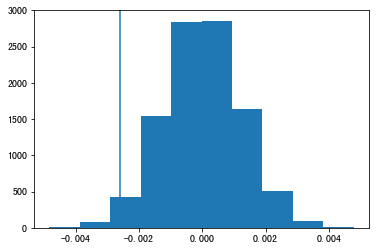

In [29]:
diffs = np.array(diffs)
plt.hist(diffs)
plt.axvline(match_diff)

在diffs列表的数值中，有多大比例小于ab_data.csv中观察到的实际差值？

In [30]:
(diffs < match_diff).mean()
# 这个值应该是同p值很接近的

0.0148